<a href="https://colab.research.google.com/github/nuoweili/personal-project/blob/main/proj_imagedata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **import data**

In [ ]:
#Google Colab users
#from google.colab import files
#uploaded = files.upload()

Saving train-2025.pkl to train-2025.pkl


In [ ]:
#uploaded = files.upload()

Saving test-2025.pkl to test-2025.pkl


In [ ]:
#uploaded = files.upload()

Saving valid-2025.pkl to valid-2025.pkl


In [ ]:

import numpy as np

def load_data(pickle_file):
  import pickle
  with open(pickle_file, "rb") as f:
    dict = pickle.load(f)
  return dict[b"data"], dict[b"labels"], dict[b"class_names"]
# now call load_data to build the training, validation, and test sets
X_train, y_train, class_names = load_data("./train-2025.pkl")
X_valid, y_valid, _ = load_data("./valid-2025.pkl")
X_test, y_test, _ = load_data("./test-2025.pkl")


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(4200, 64, 64, 3)
(4200,)
(1200, 64, 64, 3)
(1200,)
(600, 64, 64, 3)
(600,)


In [ ]:
print(class_names)

['Egyptian cat', 'birdhouse', 'bullfrog', 'cougar', 'dromedary', 'jellyfish', 'koala', 'lion', 'salamandra', 'tarantula', 'trilobite', 'walkingstick']


In [ ]:
len(class_names)

12

# **display images**

In [ ]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt

def display_images (x, y):
  n_total_images = x.shape[0]
  rand_indices = np.random.permutation(n_total_images)[:30]
  fig, axes = plt.subplots(5, 6, figsize=(10, 8))
  fig.subplots_adjust(hspace=0.5, wspace=0.3)
  for i, ax in enumerate(axes.flat):
    index = rand_indices[i]
    image = x[index]
    label_index = y[index]
    class_name = class_names[label_index]

    ax.imshow(image)
    ax.set_title(f"{class_name}")
    ax.axis("off")

  plt.show()

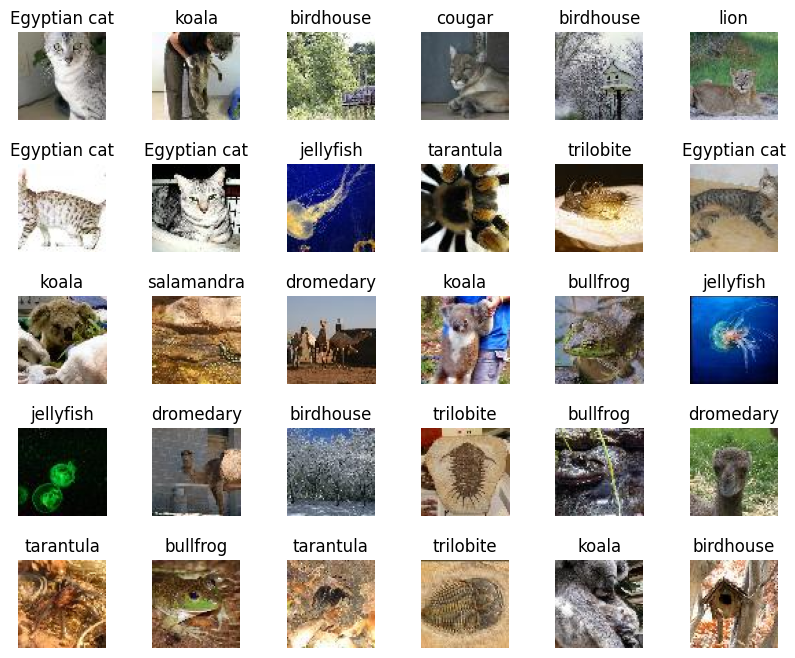

In [ ]:
display_images(X_train, y_train)

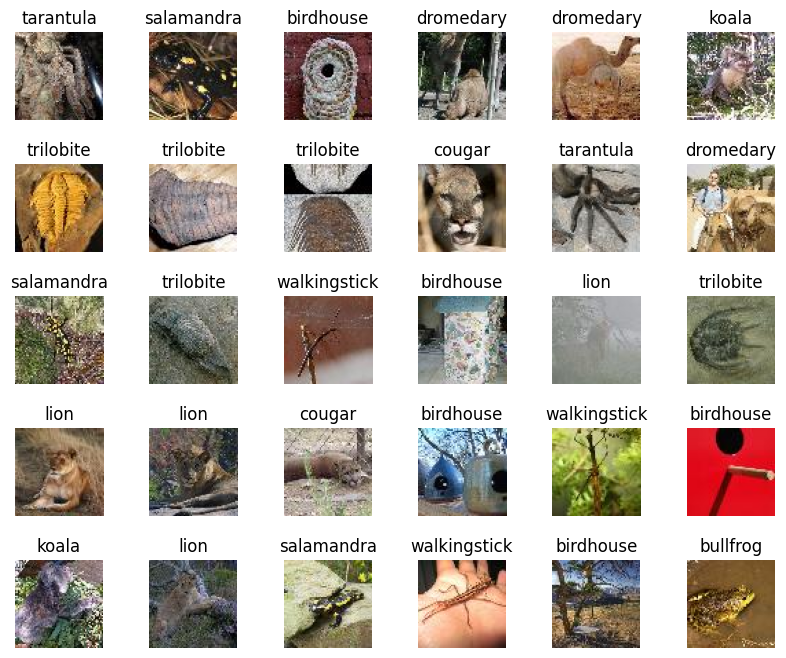

In [ ]:
display_images(X_test, y_test)

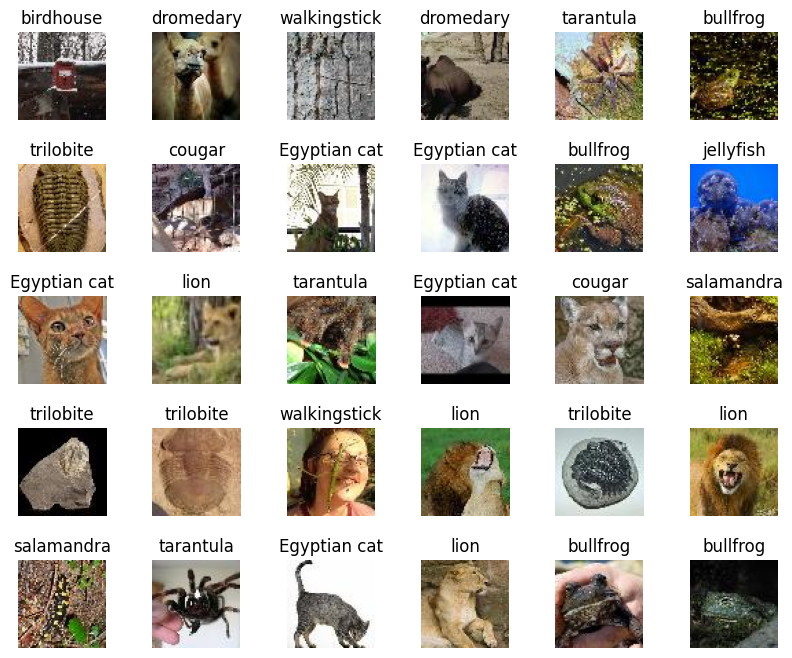

In [ ]:
display_images(X_valid, y_valid)

# **Implementation and hyperparameter tuning of a CNN model**

In [ ]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.9 MB/s eta 0:00:00


In [ ]:
hyperparameter_tuning = False

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import time
import numpy as np
import random


def build_cnn(hp):
  tf.random.set_seed(42)
  model = tf.keras.Sequential()
  #input layer
  model.add(tf.keras.layers.InputLayer(shape=[64, 64, 3]))

  for i in range(4):
    filters = hp.Int(f'filters_{i}', min_value=10, max_value=40, step=10)
    #convolutional layers
    model.add(layers.Conv2D(filters=filters, kernel_size=3, activation='leaky_relu', padding='same'))
    if i < 2:
      #bn layers after the first 2 convolutional layers
      model.add(layers.BatchNormalization())
    #pooling layers
    model.add(layers.MaxPooling2D(2))

  #dropout layer
  dropout_rate = hp.Float('dropout', 0.2, 0.5, step=0.1)
  model.add(layers.Dropout(dropout_rate))


  #pooling layer replacing flatten layer
  model.add(layers.GlobalAveragePooling2D())

  #dense layer
  units = hp.Int('dense_units', min_value=9, max_value=36, step=9)
  model.add(layers.Dense(units=units, activation='leaky_relu'))

  #output layer
  model.add(layers.Dense(12, activation='softmax'))

  #power sheduler
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=0.01,
      decay_steps=10_000,
      decay_rate=1.0,
      staircase=False
      )

  optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
tf.random.set_seed(42)
if hyperparameter_tuning:
  tuner = kt.BayesianOptimization(
      build_cnn,
      objective='val_accuracy',
      max_trials=10,
      directory='tuner_dir',
      project_name='cnn_tuning',
      overwrite=True,
      seed=42
      )

  early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
  start = time.time()
  tuner.search(X_train, y_train,
               epochs=100,
               validation_data=(X_valid, y_valid),
               callbacks=[early_stopping_cb])
  end = time.time()
  tuning_time = end - start

  best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
  best_trial.summary()

  m1_model = tuner.get_best_models(num_models=1)[0]
  m1_model.summary()

  m1_model.save("Li_Nuowei-CNN.keras")

else:
  m1_model = keras.models.load_model("Li_Nuowei-CNN.keras")
  m1_model.summary()

Trial 10 Complete [00h 00m 29s]
val_accuracy: 0.43833333253860474

Best val_accuracy So Far: 0.5249999761581421
Total elapsed time: 00h 08m 27s
Trial 05 summary
Hyperparameters:
filters_0: 10
filters_1: 20
filters_2: 40
filters_3: 20
dropout: 0.30000000000000004
dense_units: 36
Score: 0.5249999761581421


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 33 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 10)     │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 10)     │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 20)     │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 20)     │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 40)     │         7,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 20)       │         7,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 20)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 36)             │           756 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           444 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,880 (69.84 KB)

 Trainable params: 17,820 (69.61 KB)

 Non-trainable params: 60 (240.00 B)

# **Transfer learning using MobileNetV3Small**

In [ ]:
batch_size = 32
preprocess = tf.keras.Sequential([
    #resize the data
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True)
    #apply the same preprocessing step
    ,tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v3.preprocess_input)
])

train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)

valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_set = valid_set.map(lambda X, y: (preprocess(X), y)).batch(batch_size).prefetch(1)

test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_set  = test_set.map(lambda X, y: (preprocess(X), y)).batch(batch_size).prefetch(1)

In [ ]:
tf.random.set_seed(42)

base_model = keras.applications.MobileNetV3Small(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
densel = layers.Dense(60, activation="leaky_relu")(avg)
output = tf.keras.layers.Dense(12, activation="softmax")(densel)
model2 = tf.keras.Model(inputs=base_model.input, outputs=output)

/usr/local/lib/python3.12/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=0.01,
      decay_steps=10_000,
      decay_rate=1.0,
      staircase=False
      )
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
model2.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
start = time.time()
history = model2.fit(train_set, validation_data=valid_set, epochs=200, callbacks=[early_stopping_cb])
end = time.time()
training_time = end - start

Epoch 1/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 28s 140ms/step - accuracy: 0.7023 - loss: 1.1864 - val_accuracy: 0.8033 - val_loss: 0.6029
Epoch 2/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8713 - loss: 0.4401 - val_accuracy: 0.7725 - val_loss: 0.6877
Epoch 3/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9010 - loss: 0.3240 - val_accuracy: 0.8442 - val_loss: 0.5450
Epoch 4/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9109 - loss: 0.2670 - val_accuracy: 0.8200 - val_loss: 0.5935
Epoch 5/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9028 - loss: 0.3038 - val_accuracy: 0.8408 - val_loss: 0.6063
Epoch 6/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9230 - loss: 0.2317 - val_accuracy: 0.8042 - val_loss: 0.7528
Epoch 7/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9108 - loss: 0.2941 - val_accuracy: 0.8292 - val_loss: 0.6407
Epoch 8/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9150 - loss: 0.2706 

In [ ]:
for layer in model2.layers[:4]:
  print(f"Layer Name: {layer.name}, Output Shape: {layer.output.shape}, Number of Parameters: {layer.count_params()}")

Layer Name: input_layer_2, Output Shape: (None, None, None, 3), Number of Parameters: 0
Layer Name: rescaling, Output Shape: (None, None, None, 3), Number of Parameters: 0
Layer Name: conv, Output Shape: (None, None, None, 16), Number of Parameters: 432
Layer Name: conv_bn, Output Shape: (None, None, None, 16), Number of Parameters: 64


In [ ]:
for layer in model2.layers[-4:]:
  print(f"Layer Name: {layer.name}, Output Shape: {layer.output.shape}, Number of Parameters: {layer.count_params()}")

Layer Name: activation_17, Output Shape: (None, None, None, 576), Number of Parameters: 0
Layer Name: global_average_pooling2d_1, Output Shape: (None, 576), Number of Parameters: 0
Layer Name: dense_2, Output Shape: (None, 60), Number of Parameters: 34620
Layer Name: dense_3, Output Shape: (None, 12), Number of Parameters: 732


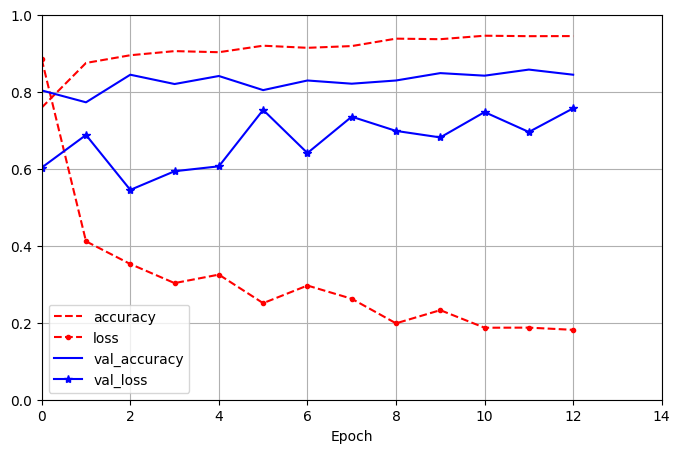

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 14], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
plt.show()

The validation loss decreased first, then increased. The model is overfitting. Reducing patience, data augmentation or use l1 l2 regularization might help preventing the overfitting problem.

In [ ]:
model2.save("Li_Nuowei-MobileNetV3Small.keras")

# **Comparisons**

In [ ]:
m1_model = keras.models.load_model("Li_Nuowei-CNN.keras")
m2_model = keras.models.load_model("Li_Nuowei-MobileNetV3Small.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 33 variables whereas the saved optimizer has 1 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
print(f"tuning time: {tuning_time:.2f} seconds")

tuning time: 506.90 seconds


In [ ]:
print(f"training time: {training_time:.2f} seconds")

training time: 75.06 seconds


The training time of pretrained model is much less than the tuning time of self trained model.

In [ ]:
print(f"cnn model trainable parameters: {m1_model.count_params()}")
print(f"retrained model trainable parameters: {sum([np.prod(w.shape) for w in m2_model.trainable_weights])}")

cnn model trainable parameters: 17880
retrained model trainable parameters: 35352


the retrained model has 3 times trainable paremeters more than cnn model's trainable paremeters. While the training time is much less.

In [ ]:
from sklearn.metrics import classification_report

y_pred_m1 = m1_model.predict(X_test).argmax(axis=1)
y_pred_m2 = m2_model.predict(X_test).argmax(axis=1)

print("cnn model performance:")
print(classification_report(y_test, y_pred_m1, target_names=class_names))

print("retrained model performance:")
print(classification_report(y_test, y_pred_m2, target_names=class_names))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step
cnn model performance:
              precision    recall  f1-score   support

Egyptian cat       0.48      0.20      0.28        50
   birdhouse       0.33      0.58      0.42        50
    bullfrog       0.48      0.64      0.55        50
      cougar       0.35      0.52      0.42        50
   dromedary       0.54      0.58      0.56        50
   jellyfish       0.69      0.86      0.77        50
       koala       0.49      0.40      0.44        50
        lion       0.57      0.40      0.47        50
  salamandra       0.82      0.80      0.81        50
   tarantula       0.54      0.26      0.35        50
   trilobite       0.60      0.48      0.53        50
walkingstick       0.46      0.42      0.44        50

    accuracy                           0.51       600
   macro avg       0.53      0.51      0.50       600
weighted avg       0.53      0.51      0.50       600

retrained model performance:


**cnn model:**
test accuracy is similar to the validation accuracy for self trained model. The model performed well for jellyfish and salamandra. Performace for other class are bad, espically cougar.


**retrained model:**
test accuracy is much lower to the validation accuracy for pretrained model. The model is overfitting. Only the performance for jellyfish and trilobite are acceptable. Performace for other class are bad.



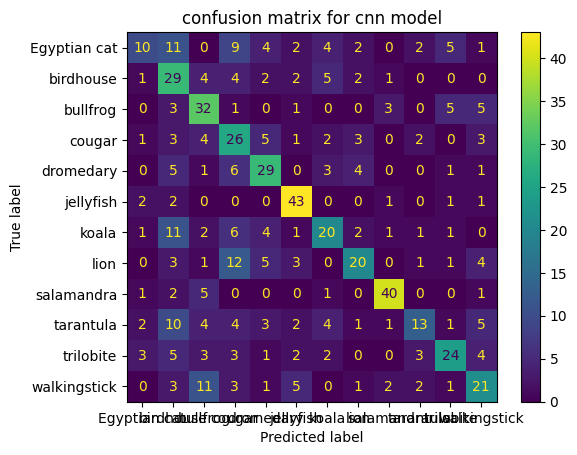

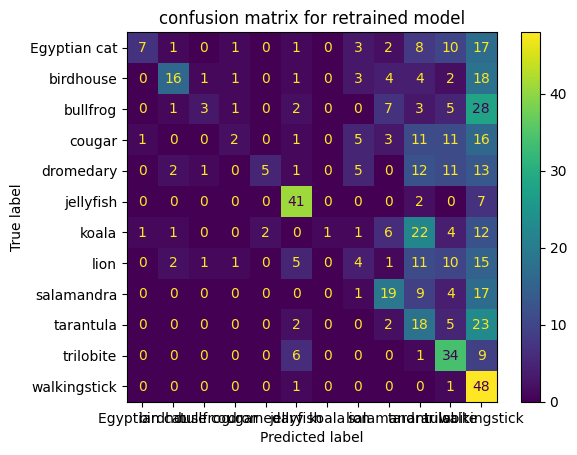

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_m1, display_labels=class_names)
plt.title("confusion matrix for cnn model")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_m2, display_labels=class_names)
plt.title("confusion matrix for retrained model")
plt.show()

the diagonal is usually the brightest cell in cnn model, meaning most instances can be corretly predicted.

In the retrained model confusion matrix, most instances are mistakenly predicted as walkingstick, trilobite or tarantula.

In [ ]:
both_c = np.where((y_pred_m1 == y_test) & (y_pred_m2 == y_test))[0]
both_w = np.where((y_pred_m1 != y_test) & (y_pred_m2 != y_test))[0]
m1c_m2w = np.where((y_pred_m1 == y_test) & (y_pred_m2 != y_test))[0]
m1w_m2c = np.where((y_pred_m1 != y_test) & (y_pred_m2 == y_test))[0]

def show_examples(index, x, y_true, y_pred1, y_pred2, title):
  fig, axes = plt.subplots(4, 5, figsize=(10, 8))
  fig.subplots_adjust(hspace=1, wspace=0.3)
  fig.suptitle(title, fontsize = 14)
  rand_idx = np.random.permutation(index)[:20]
  for i, ax in enumerate(axes.flat):
    idx = rand_idx[i]
    image = x[idx]
    label_true = y_true[idx]
    label_pred1 = y_pred1[idx]
    label_pred2 = y_pred2[idx]

    ax.imshow(image)
    ax.set_title(f"true: {class_names[label_true]}\nm1: {class_names[label_pred1]}\nm2: {class_names[label_pred2]}")
    ax.axis("off")
  plt.show()

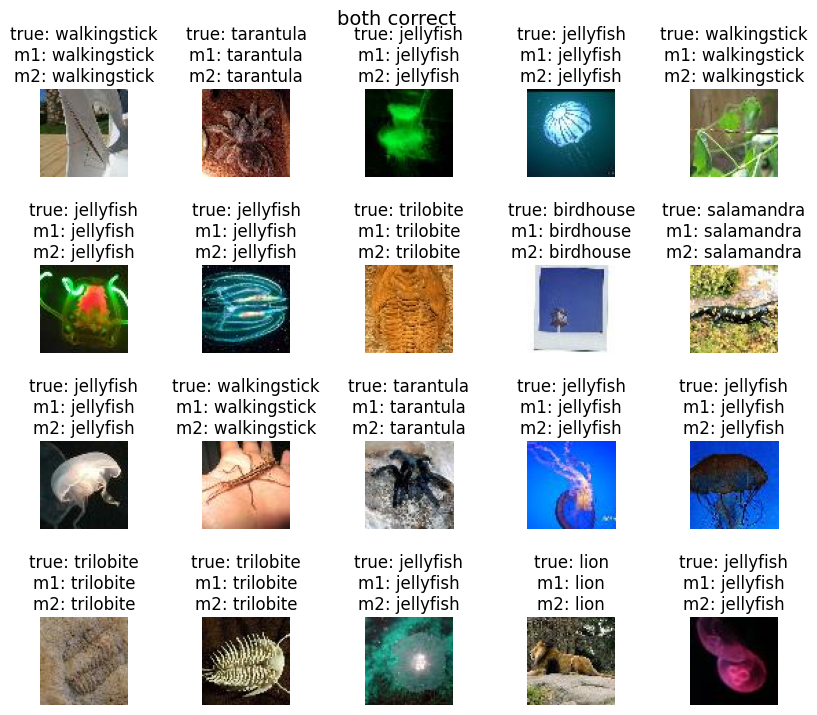

In [ ]:
show_examples(both_c, X_test, y_test, y_pred_m1, y_pred_m2, "both correct")

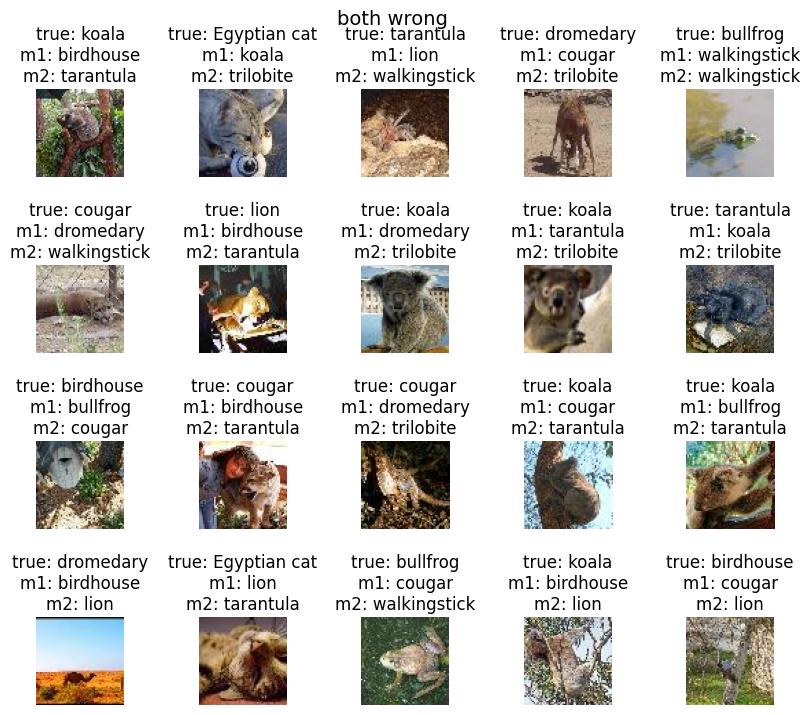

In [ ]:
show_examples(both_w, X_test, y_test, y_pred_m1, y_pred_m2, "both wrong")

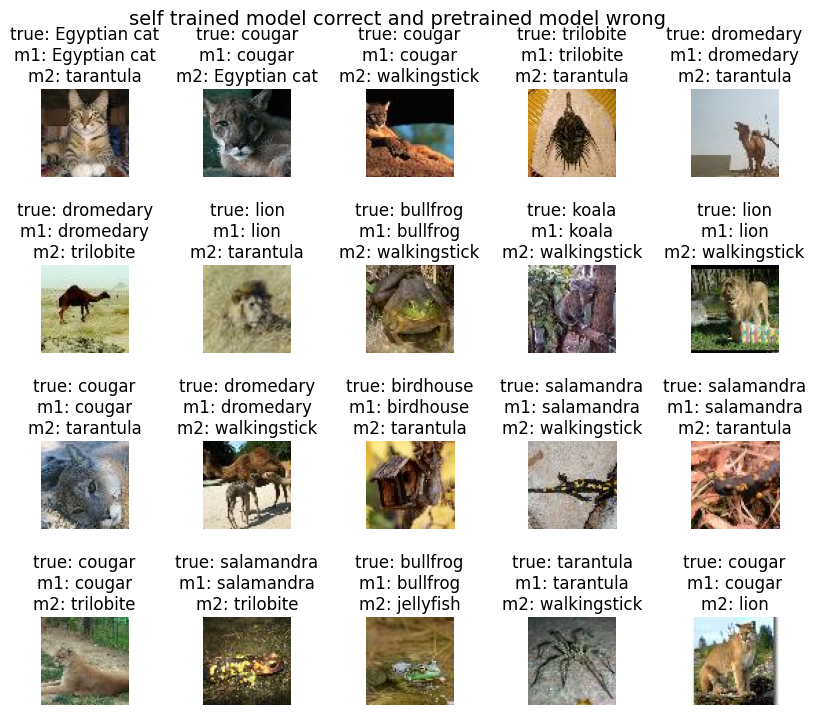

In [ ]:
show_examples(m1c_m2w, X_test, y_test, y_pred_m1, y_pred_m2, "self trained model correct and pretrained model wrong")

retrained model usually mistakenly predict images as walkingstick, trilobite or tarantula, which aligns with the confusion matrix

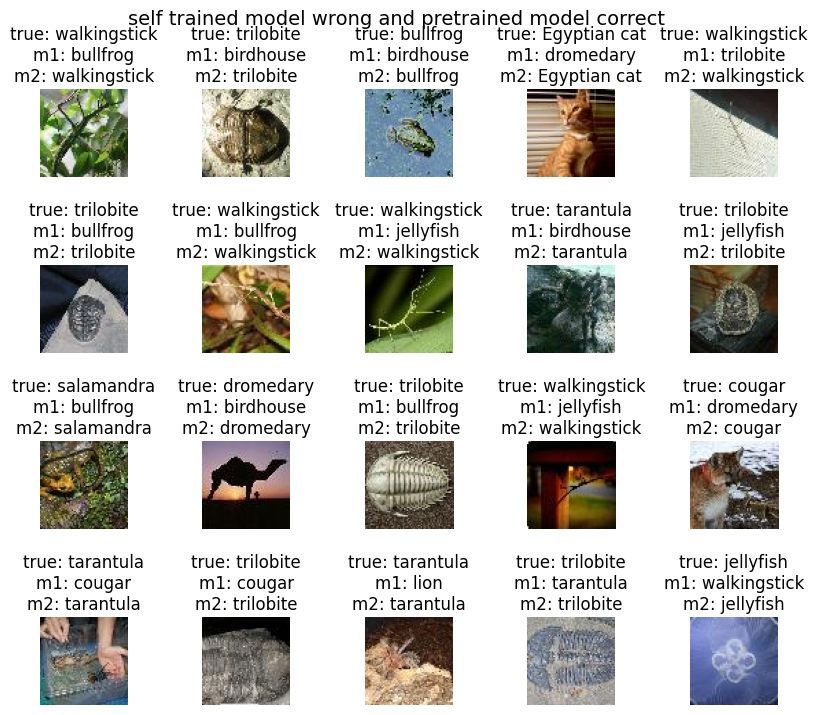

In [ ]:
show_examples(m1w_m2c, X_test, y_test, y_pred_m1, y_pred_m2, "self trained model wrong and pretrained model correct")

## total summary

The cnn model have better generalization on the test set, although having fewer parameters and requiring more tuning time.

The retrained model was overfitting, applying more tuning process should help preventing overfitting and improve the performace (e.g. reducing patience or use l1 l2 regularization).

For this dataset, the smaller cnn model was more robust than the larger retrained model.